In [1]:
import pathlib
from itertools import cycle

import numpy as np
import pandas as pd
from ase.io import read
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from matplotlib.ticker import FixedLocator

from tasks_si import (
    compute_voronoi_statistics, 
    gather_radial_distribution_functions,
    gather_ring_statistics,
    gather_logs,
    plot_mc_energy,
    plot_md_energy,
    plot_averaged_hrmc_rdfs,
    plot_structure_factor,
    retrieve_and_process_hrmc_data
)

from scripts.plot import *
from scripts.molecules import calcium, carbonate, water, MoleculeProcessor

---
### Evolution of system properties during HRMC refinement and MD simulations

In [2]:
hrmc_costs = pd.read_csv(
    'simulations/hrmc/trajectory/log_tot.txt',
)
hrmc_traj = pd.read_csv(
    'simulations/hrmc/trajectory/hrmc_trajectory.csv'
)
hrmc_md_nvt_traj = pd.read_csv(
    'simulations/hrmc/molecular_dynamics/hrmc_md_nvt_trajectory.csv'
)
mhc_md_nvt_traj = pd.read_csv(
    'simulations/hrmc/molecular_dynamics/mhc_md_nvt_trajectory.csv'
)

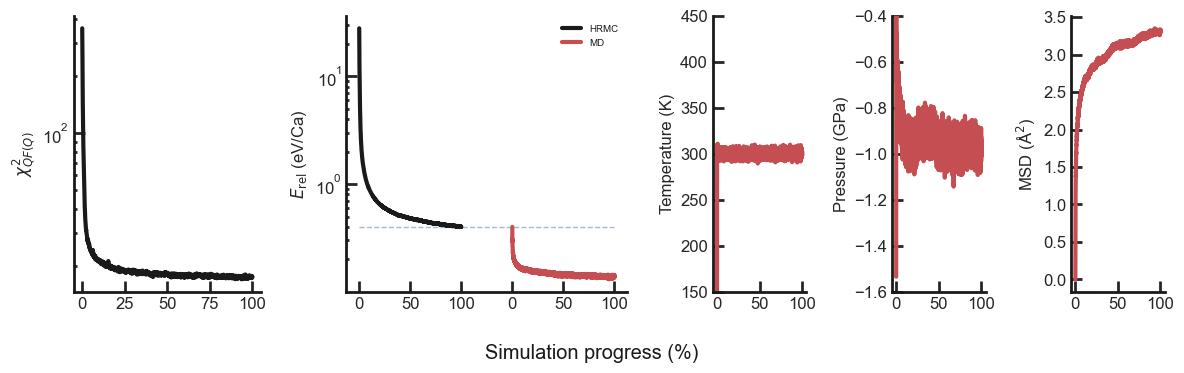

In [3]:
# Define styles
styles = {
    'HRMC': {'color': 'k', 'linestyle': '-'},
    'MD': {'color': 'r', 'linestyle': '-'},
    'dashed': {'linestyle': 'dashed', 'alpha': 0.5, 'lw': 1}
}



# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(12, 3.75),
                       gridspec_kw={'width_ratios': [2, 3, 1, 1, 1]})

# First subplot
plot_on_ax(
    ax[0], 
    np.linspace(0, 100, len(hrmc_costs)), 
    hrmc_costs['F(Q)'], 
    styles['HRMC']
)
ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(0, 125, 25))
ax[0].set_ylabel(r'$\chi^2_{QF(Q)}$')

# Second subplot
rel_energy = hrmc_traj['Energy (eV/FU)'] - mhc_md_nvt_traj['Energy (eV/FU)'].iloc[-1]
plot_on_ax(ax[1], hrmc_traj['Step'] * 100 / hrmc_traj['Step'].max(), rel_energy, styles['HRMC'], label='HRMC')
plot_on_ax(
    ax[1],
    (hrmc_md_nvt_traj['Step'] * 100 / hrmc_md_nvt_traj['Step'].max()) + 150,
    hrmc_md_nvt_traj['Energy (eV/FU)'] - mhc_md_nvt_traj['Energy (eV/FU)'].iloc[-1],
    styles['MD'], label='MD'
)

add_hlines(ax[1], rel_energy.iloc[-1], 0, 250, styles['dashed'])
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$E_{\rm rel}$ (eV/Ca)')
ax[1].xaxis.set_major_locator(FixedLocator([0, 50, 100, 150, 200, 250]))
ax[1].set_xticklabels([0, 50, 100, 0, 50, 100])
ax[1].legend(fontsize=7, frameon=False)

# Subplots 3 to 5
for i, label in enumerate(['Temperature (K)', 'Pressure (GPa)', 'MSD (Å$^2$)'], 2):
    plot_on_ax(ax[i], hrmc_md_nvt_traj['Step'] * 100 / hrmc_md_nvt_traj['Step'].max(), hrmc_md_nvt_traj[label], styles['MD'])
    ax[i].set_ylabel(label)
    ax[i].set_xticks(np.arange(0, 125, 50))

# Additional settings
ax[2].set_ylim([150, 450])
ax[3].set_ylim([-1.6, -0.4])
fig.supxlabel('Simulation progress (%)')

plt.tight_layout()
plt.savefig('figures/si/figS1.pdf', dpi=600)
plt.show()

---
### Evolution of coarse-grained ensemble energies

In [4]:
mc_logs = gather_logs(method='monte_carlo')
md_logs = gather_logs(method='molecular_dynamics')

In [5]:
# find minimimum energy structure across all MD runs.
all_md_energies = []
for data in md_logs.values():
    all_md_energies.append(data.gather_property('TotEng', data_start=0).min())
all_md_energies = np.array(all_md_energies)
md_min_energy = all_md_energies.min()
per_ca = all_md_energies / 1620
print(f'Average energy: {np.average(per_ca):.5f} +/- {np.std(per_ca):.5f} eV/Ca')

Average energy: -0.03028 +/- 0.00090 eV/Ca


In [6]:
all_mc_energies = []
for data in mc_logs.values():
    ix = data['headers'].index('curr_e')
    all_mc_energies.append(data['data'][:,ix].min())
all_mc_energies = np.array(all_mc_energies)
mc_min_energy = all_mc_energies.min()
print(f'Average energy: {np.average(all_mc_energies):.5f} +/- {np.std(all_mc_energies):.5f} eV/Ca')

Average energy: -0.00413 +/- 0.00029 eV/Ca


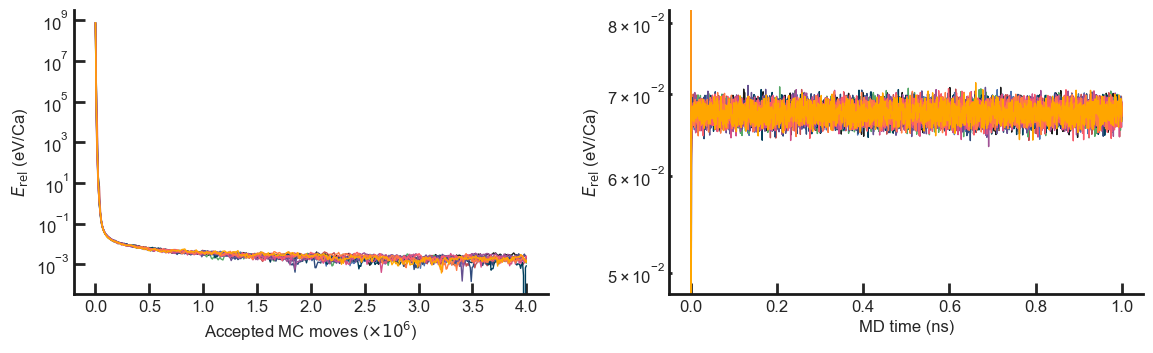

In [7]:
cols = cycle(
    ['k', 'r', 'b', 'g'] + \
    "#003f5c #2f4b7c #665191 #a05195 #d45087 #f95d6a #ff7c43 #ffa600".split()
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for data in mc_logs.values():
    plot_mc_energy(axes[0], data, next(cols), energy_baseline=mc_min_energy)

for data in md_logs.values():
    plot_md_energy(
        axes[1], data, next(cols), skipblocks=0, energy_baseline=md_min_energy
    )

axes[0].set_yscale('log')
axes[0].set_ylabel(r'$E_{\rm rel}$ (eV/Ca)')
axes[0].set_xlabel(r'Accepted MC moves ($\times 10^6$)')

axes[1].set_ylim([4.8*10**(-2), 8.2*10**(-2)])
axes[1].set_yscale('log')
axes[1].set_ylabel(r'$E_{\rm rel}$ (eV/Ca)')
axes[1].set_xlabel(r'MD time (ns)')

plt.tight_layout(pad=2)
plt.savefig('figures/si/figS2.pdf')
plt.show()

---
### Partial pair distribution functions

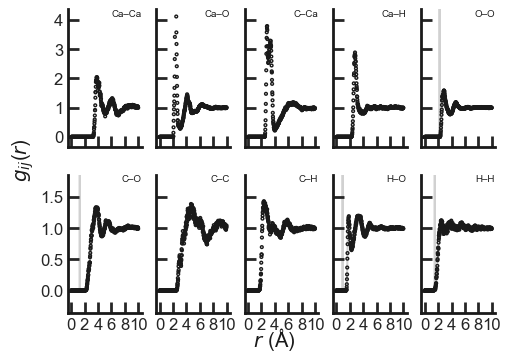

In [8]:
# specify the order of the plots.
plot_order = [
    'Ca_Ca', 'Ca_O', 'C_Ca', 'Ca_H', 'O_O', 'C_O', 'C_C', 'C_H', 'H_O', 'H_H'
]

# specify which pairs will also be included as intra-molecular.
intra_mol = ['O_O', 'C_O', 'H_O', 'H_H']

# plot the figure.
fig, axes = plt.subplots(2, 5, figsize=(14*cm,10*cm), sharex=True, sharey='row')
plot_averaged_hrmc_rdfs(axes, plot_order, include_intramolecular=intra_mol)
fig.supylabel(r'$g_{ij}$($r$)')
fig.supxlabel(r'$r~$(Å)')
plt.savefig('figures/si/figS3.pdf', dpi=600)
plt.show()

---
### Key bond-length and bond-angle distributions

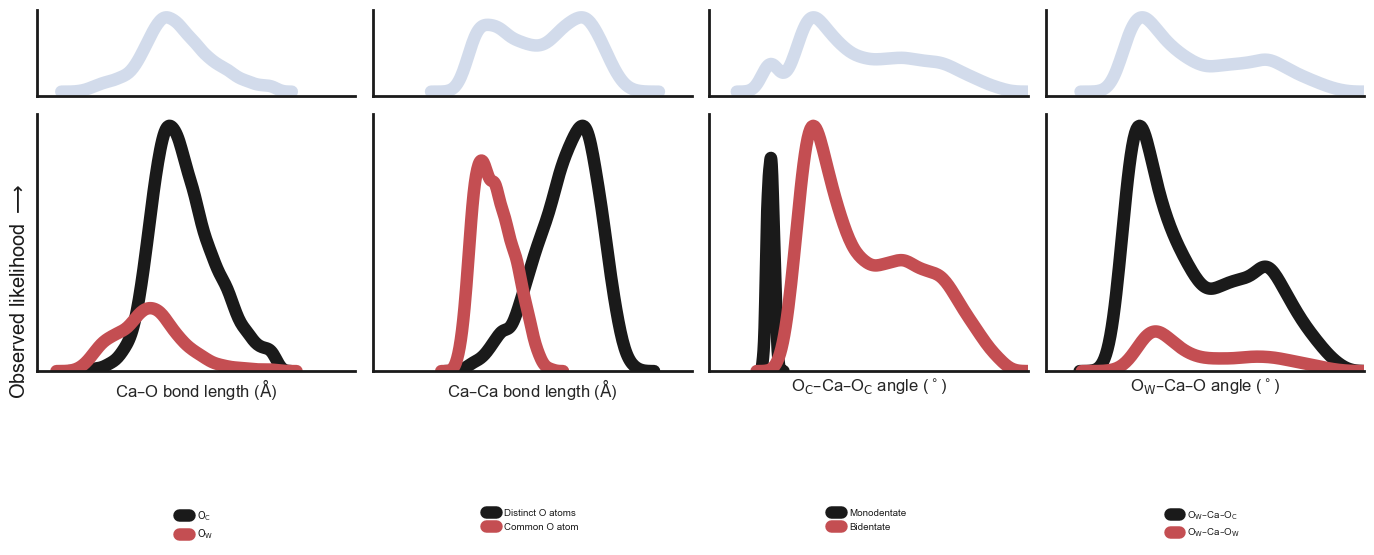

In [9]:
# Process and plot the data
results = retrieve_and_process_hrmc_data()
fig, ax = create_subplots()

# set line width for all plots.
lw=9

# Create the plots
plot_kde(ax[1, 0], results['distances']['d_ca_ow'], results['distances']['d_ca_oc'], lw=lw)
plot_kde(ax[0, 0], np.concatenate([results['distances']['d_ca_oc'], results['distances']['d_ca_ow']]), color='k', alpha=0.25, lw=lw)

plot_kde(ax[1, 1], results['distances']['d_ca_ca'][1], results['distances']['d_ca_ca'][0], lw=lw)
plot_kde(ax[0, 1], np.concatenate([results['distances']['d_ca_ca'][0] + results['distances']['d_ca_ca'][1]]), color='k', alpha=0.25, lw=lw)

plot_kde(ax[1, 2], results['angles']['oc_ca_o_different'], results['angles']['oc_ca_oc_same'], lw=lw)
plot_kde(ax[0, 2], np.concatenate([results['angles']['oc_ca_o_different'], results['angles']['oc_ca_oc_same']]), color='k', alpha=0.25, lw=lw)

plot_kde(ax[1, 3], results['angles']['ow_ca_ow'], results['angles']['ow_ca_oc'], lw=lw)
plot_kde(ax[0, 3], np.concatenate([results['angles']['ow_ca_ow'], results['angles']['ow_ca_oc']]), color='k', alpha=0.25, lw=lw)

# Set properties for each axes
set_axis_properties(ax[1, 0], [r'$\rm O_{C}$', r'$\rm O_{W}$'], [1.9, 3.1], np.arange(2.0, 3.25, 0.5), r'Ca–O bond length ($\rm \AA{}$)')
set_axis_properties(ax[1, 1], [r'Distinct O atoms', r'Common O atom'], [1.5, 8.5], np.arange(2.0, 9.25, 2), r'Ca–Ca bond length ($\rm \AA{}$)')
set_axis_properties(ax[1, 2], [r'Monodentate', r'Bidentate'], [20, 190], np.arange(30, 185, 30), r'O$_{\rm C}$–Ca–O$_{\rm C}$ angle ($^\circ$)')
set_axis_properties(ax[1, 3], [r'O$_{\rm W}$–Ca–O$_{\rm C}$', r'O$_{\rm W}$–Ca–O$_{\rm W}$'], [20, 190], np.arange(30, 185, 30), r'O$_{\rm W}$–Ca–O angle ($^\circ$)')

ax[0, 0].set_ylabel(r'Total')
ax[1, 0].set_ylabel(r'Component')
fig.supylabel(r'Observed likelihood $\longrightarrow$')
format_bond_and_angles_axes(ax)

plt.tight_layout()
plt.savefig('figures/si/figS4.pdf')
plt.show()

---
### Consistency with neutron total scattering measurements

In [10]:
# load experimental datasets.
sq_n_jensen2018 = np.loadtxt(
    'previously_published_data_for_comparison/neutron/jensen2018_jphyschemc_sq.csv', delimiter=','
)
sq_n_coubourne2014 = np.loadtxt(
    'previously_published_data_for_comparison/neutron/coubourne2014_jnoncryssol_sq.csv', delimiter=','
)
sq_n_wang2017 = np.loadtxt(
    'previously_published_data_for_comparison/neutron/wang2017_jchemcomm_sq.csv', delimiter=','
)

# load simulation structure properties.
path2struct = pathlib.Path('simulations/hrmc/structure')
path2data = pathlib.Path('simulations/hrmc/rdfs/intra/1500')

element_pairs = np.load(path2data / 'elementPairs.npy')
rs = np.load(path2data / 'rs.npy')
rdfs = np.load(path2data / 'rdf.npy')
unique_elements = np.unique(element_pairs)

structure = Structure.from_file(path2struct / 'HRMC_150M_proposed_moves.cif')
rho0 = len(structure) / structure.lattice.volume
qs = np.arange(0.01, 22, 0.1)
composition = structure.composition

# compile data into list.
frame_data = [composition, rs, element_pairs, rdfs, rho0, unique_elements]

/Users/tcnicholas/miniconda3/envs/cgzif2023/lib/python3.9/site-packages/pymatgen/io/cif.py:1150: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


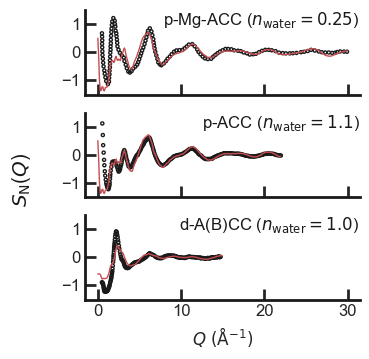

In [11]:
# define constants for annotations.
DEFAULT_ANNOTATION_ARGS = {
    'xy': (1, 1), 
    'xycoords': 'axes fraction', 
    'fontsize': 12, 
    'horizontalalignment': 'right', 
    'verticalalignment': 'top'
}

# gather the datasets together for plotting.
DATASETS = [
    {
        'name': 'coubourne2014',
        'args': {
            'q_range': (0.01, 30, 0.1), 
            'deuteration_fraction': 0.0, 
            'expt_args': {'y_offset': 0.0, 'scale_factor': 10.0, 's': 5}, 
            'line_args': {'c':'r', 'lw':1}
        },
        'sq_n': sq_n_coubourne2014,
        'annotation_args': {'text': r'p-Mg-ACC ($n_{\rm water}=0.25$)'}
    },
    {
        'name': 'jensen2018',
        'args': {
            'q_range': (0.01, 22, 0.1), 
            'deuteration_fraction': 0.0, 
            'expt_args': {'y_offset': -0.2, 'scale_factor': 10.0, 's': 5}, 
            'line_args': {'c':'r', 'lw':1}
        },
        'sq_n': sq_n_jensen2018,
        'annotation_args': {'text': r'p-ACC ($n_{\rm water}=1.1$)'}
    },
    {
        'name': 'wang2017',
        'args': {
            'q_range': (0.01, 15, 0.1), 
            'deuteration_fraction': 0.9, 
            'expt_args': {'y_offset': -1, 'scale_factor': 1.0, 's': 5}, 
            'line_args': {'c':'r', 'lw':1}
        },
        'sq_n': sq_n_wang2017,
        'annotation_args': {'text': r'd-A(B)CC ($n_{\rm water}=1.0$)'}
    }
]


fig, ax = plt.subplots(3,1,figsize=(3.75,3.75),sharex=True,sharey=True)

for i, data in enumerate(DATASETS):
    plot_structure_factor(ax[i], data['sq_n'], *frame_data, **data['args'])
    annotation_args = DEFAULT_ANNOTATION_ARGS.copy()
    annotation_args.update(data['annotation_args'])
    ax[i].annotate(**annotation_args)

ax[2].set_ylim(-1.5, 1.5)
ax[2].set_xlabel(r'$Q~{\rm(\AA{}^{-1})}$')
fig.supylabel(r'$S_{\rm N}$($Q$)')

plt.tight_layout()
plt.savefig('figures/si/figS5.pdf', dpi=600)
plt.show()

---
### The role of water in ACC

In [12]:
# load the data from the csv files.
rdf_Oc_Ow = np.loadtxt('data/computed/water_rdf_Oc_Ow.csv', delimiter=',')
rdf_Oc_H = np.loadtxt('data/computed/water_rdf_Oc_H.csv', delimiter=',')
rdf_Ow_Ow = np.loadtxt('data/computed/water_rdf_Ow_Ow.csv', delimiter=',')
rdf_Ow_H = np.loadtxt('data/computed/water_rdf_Ow_H.csv', delimiter=',')

# cluster size histogram.
water_cluster_sizes = np.loadtxt(
    'data/computed/water_cluster_sizes.csv', delimiter=','
)

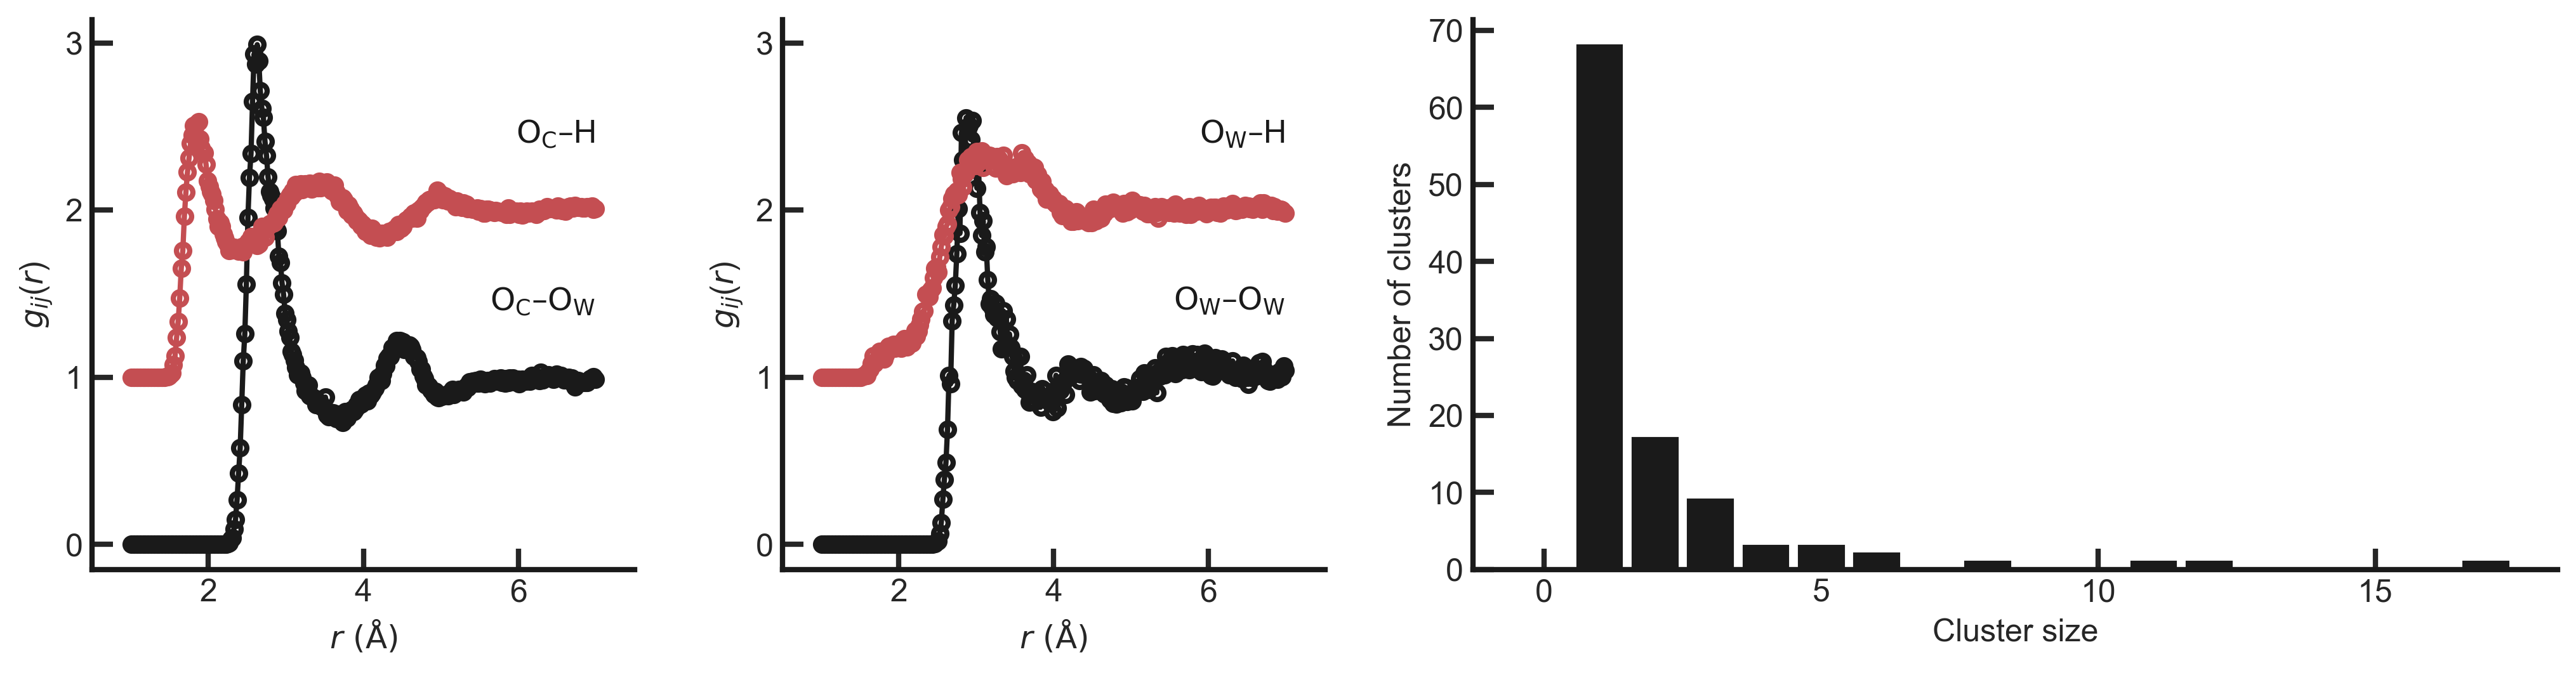

In [13]:
r_min = 1.0
r_max = 7.0

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), dpi=300, 
    gridspec_kw={'width_ratios':[1,1,2]})

# carbonate oxygen based rdfs.
plot_between_cutoffs(
    ax[0], rdf_Oc_Ow, r_min, r_max, r'$\rm O_{C}$–$\rm O_{W}$'
)
plot_between_cutoffs(
    ax[0], rdf_Oc_H, r_min, r_max, r'$\rm O_{C}$–H', offset=1, color='r'
)

# water oxygen based rdfs.
plot_between_cutoffs(
    ax[1], rdf_Ow_Ow, r_min, r_max, r'$\rm O_{W}$–$\rm O_{W}$'
)
plot_between_cutoffs(
    ax[1], rdf_Ow_H, r_min, r_max, r'$\rm O_{W}$–H', offset=1, color='r'
)

# water cluster sizes.
ax[2].bar(*water_cluster_sizes.T, width=0.8, edgecolor='k', color='k', alpha=1.0)

ax[0].set_xticks(np.arange(2,8,2))
ax[1].set_xticks(np.arange(2,8,2))
ax[0].set_xlim([0.5,7.5])
ax[1].set_xlim([0.5,7.5])

ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_xlabel(r'$r~{\rm(\AA{})}$')
ax[1].set_xlabel(r'$r~{\rm(\AA{})}$')
ax[1].set_yticks([0,1,2,3])
ax[0].set_yticks([0,1,2,3])
ax[0].set_ylabel(r'$g_{ij}$($r$)')
ax[1].set_ylabel(r'$g_{ij}$($r$)')

ax[2].set_xticks(np.arange(0,17,5))
ax[2].set_xlabel(r'Cluster size')
ax[2].set_ylabel(r'Number of clusters')

plt.tight_layout(pad=2)
plt.savefig('figures/si/figS6.pdf', dpi=600)
plt.show()

---
### Comparing calcium-ion distributions in HRMC and LJG configurations

In [14]:
rdfs = {
    'hrmc': gather_radial_distribution_functions(model='hrmc'),
    'ljg_mc': gather_radial_distribution_functions(model='ljg', method='monte_carlo'),
    'ljg_md': gather_radial_distribution_functions(model='ljg', method='molecular_dynamics'),
}

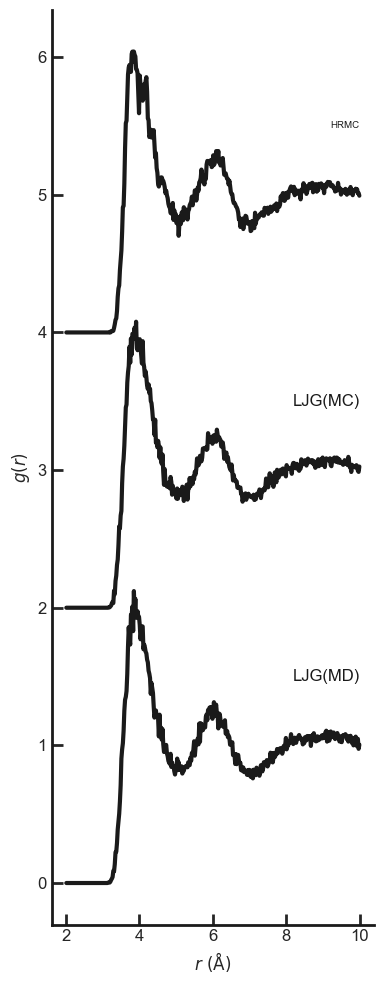

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,10), dpi=100)
plot_rdf(ax, rdfs['hrmc']['r_values'], rdfs['hrmc']['rdfs']+4)
plot_rdf(ax, rdfs['ljg_mc']['r_values'], rdfs['ljg_mc']['rdfs'].mean(axis=0)+2)
plot_rdf(ax, rdfs['ljg_md']['r_values'], rdfs['ljg_md']['rdfs'].mean(axis=0))

ax.text(10.0, 5.5, 'HRMC', ha='right', va='center', fontsize=7)#, transform=ax.transAxes)
ax.text(10.0, 3.5, 'LJG(MC)', ha='right', va='center')#, transform=ax.transAxes)
ax.text(10.0, 1.5, 'LJG(MD)', ha='right', va='center')#, transform=ax.transAxes)

ax.set_xticks(np.arange(2,12,2))
ax.set_xlabel(r'$r~{\rm(\AA{})}$')
ax.set_ylabel(r'$g(r)$')
plt.tight_layout()
plt.show()

In [16]:
voronoi_statistics = {
    'hrmc': compute_voronoi_statistics(model='hrmc'),
    'ljg_mc': compute_voronoi_statistics(model='ljg', method='monte_carlo'),
    'ljg_md': compute_voronoi_statistics(model='ljg', method='molecular_dynamics'),
}

In [17]:
ring_statistics = {
    'hrmc': gather_ring_statistics(model='hrmc'),
    'ljg_mc': gather_ring_statistics(model='ljg', method='monte_carlo'),
    'ljg_md': gather_ring_statistics(model='ljg', method='molecular_dynamics'),
}

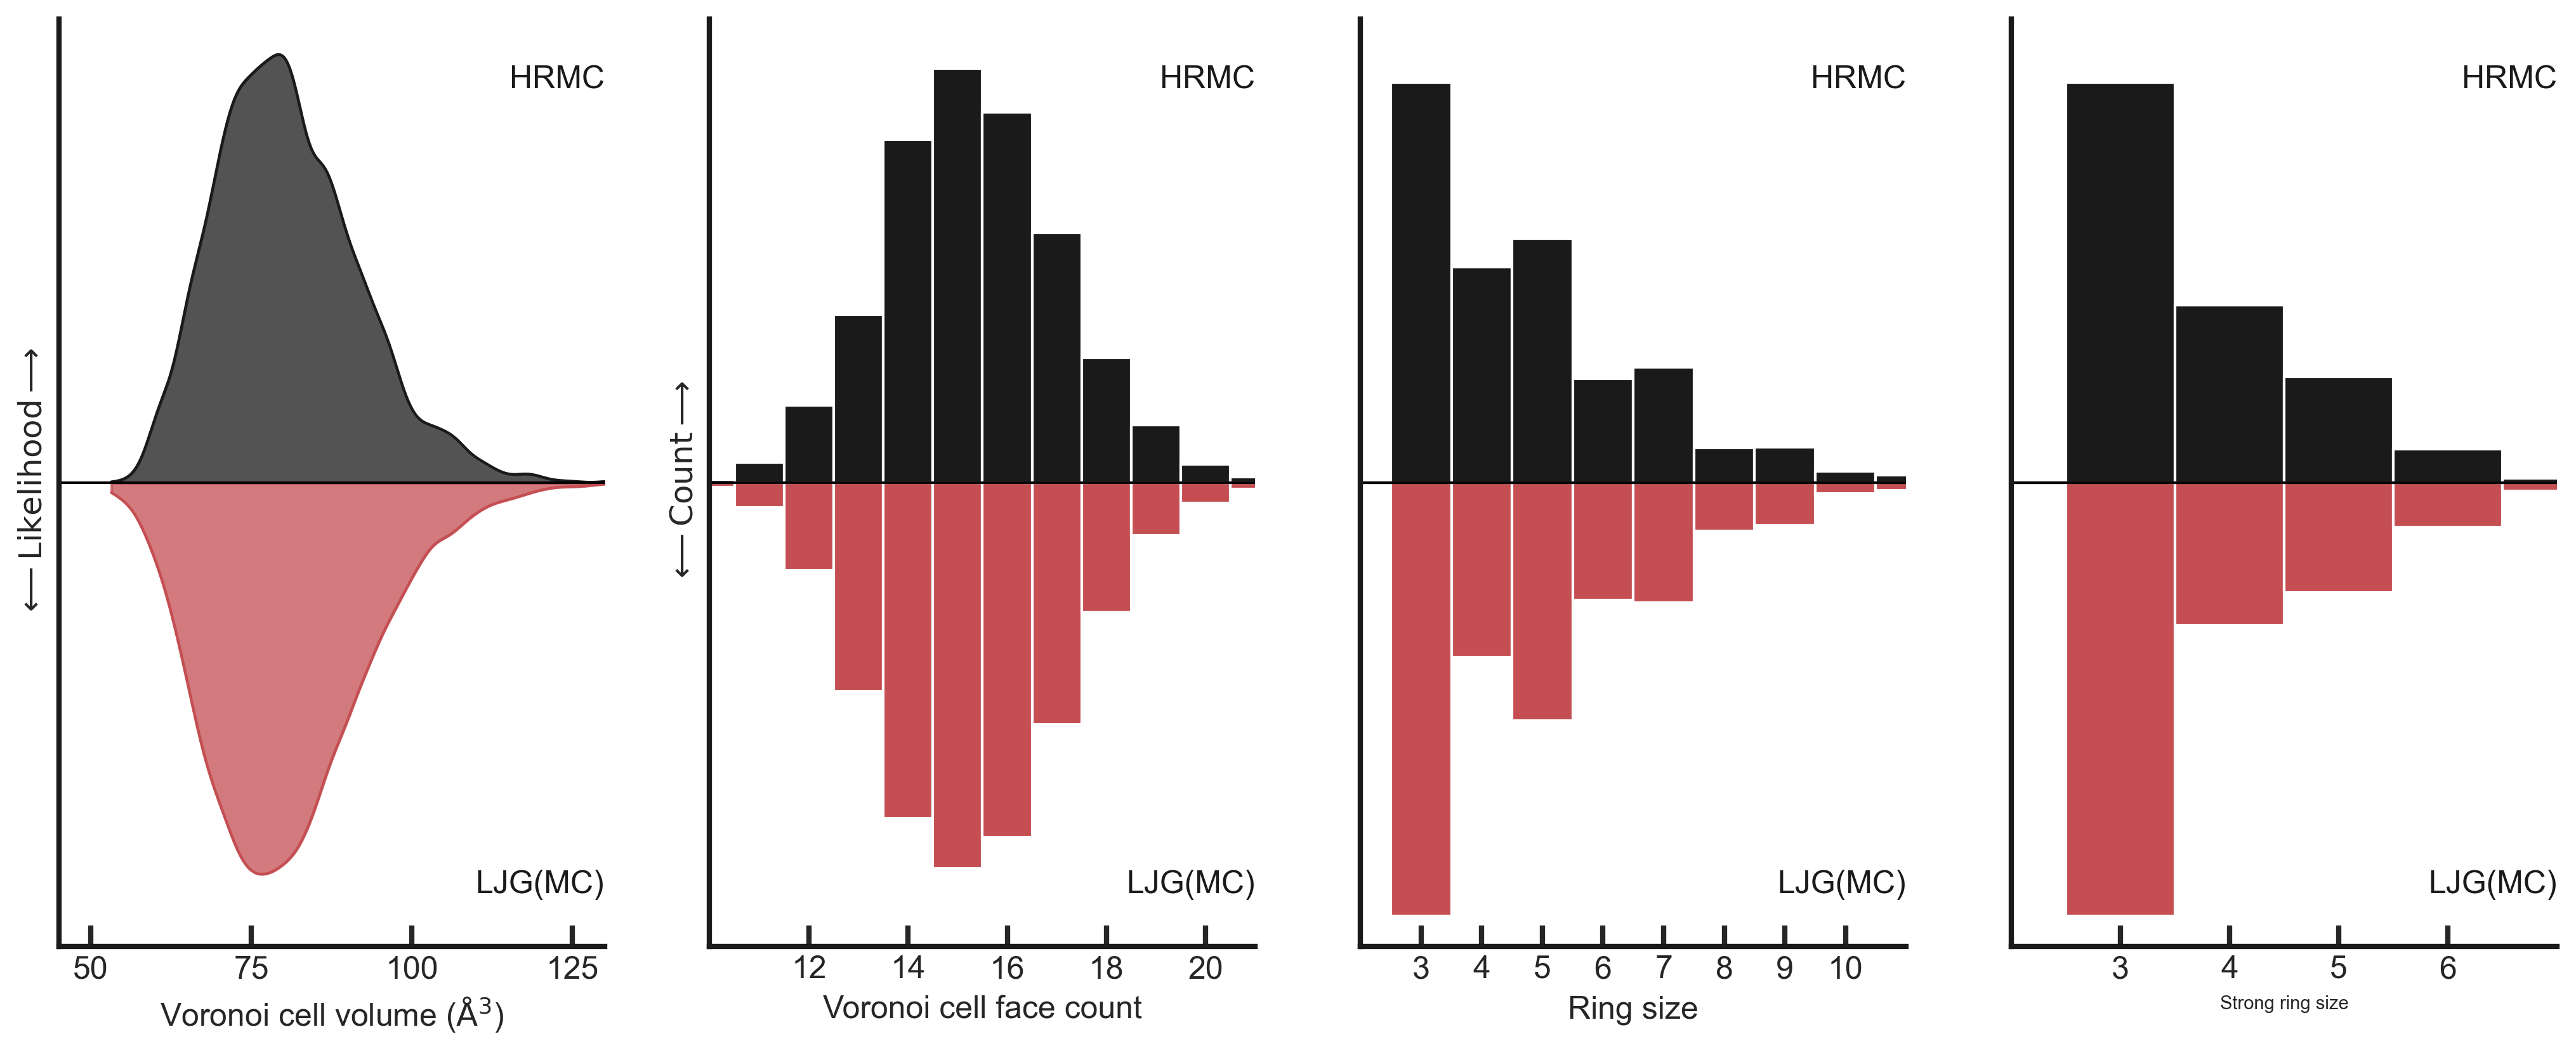

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 6), dpi=300)

left, width = .25, .1
bottom, height = .25, .1
right = left + width
top = bottom + height

# voronoi volume kde.
xrange = plot_voronoi_volume_kde(
    axes[0], voronoi_statistics, model='hrmc'
)
plot_voronoi_volume_kde(
    axes[0], voronoi_statistics, model='ljg_mc', xrange=xrange, colour='r'
);
axes[0].axhline(y=0, linestyle='-',linewidth=1, color='black')

# voronoi neighbours histogram.
plot_voronoi_neighbour_histogram(
    axes[1], voronoi_statistics, model='hrmc'
)
plot_voronoi_neighbour_histogram(
    axes[1], voronoi_statistics, model='ljg_mc', colour='r'
)
axes[1].axhline(y=0, linestyle='-',linewidth=1, color='black')

# ring statistics.
plot_ring_counts(axes[2], ring_statistics, model='hrmc')
plot_ring_counts(axes[2], ring_statistics, model='ljg_mc')

# strong ring statistics.
plot_ring_counts(axes[3],  ring_statistics, model='hrmc', 
    ring_type='strong_rings'
)
plot_ring_counts(axes[3], ring_statistics, model='ljg_mc', 
    ring_type='strong_rings'
)

label_top_and_bottom_axes(axes)
fig.subplots_adjust(bottom=0.3, wspace=0.33)
plt.tight_layout(pad=2)
plt.savefig('figures/si/figS7.pdf', dpi=600)
plt.show()

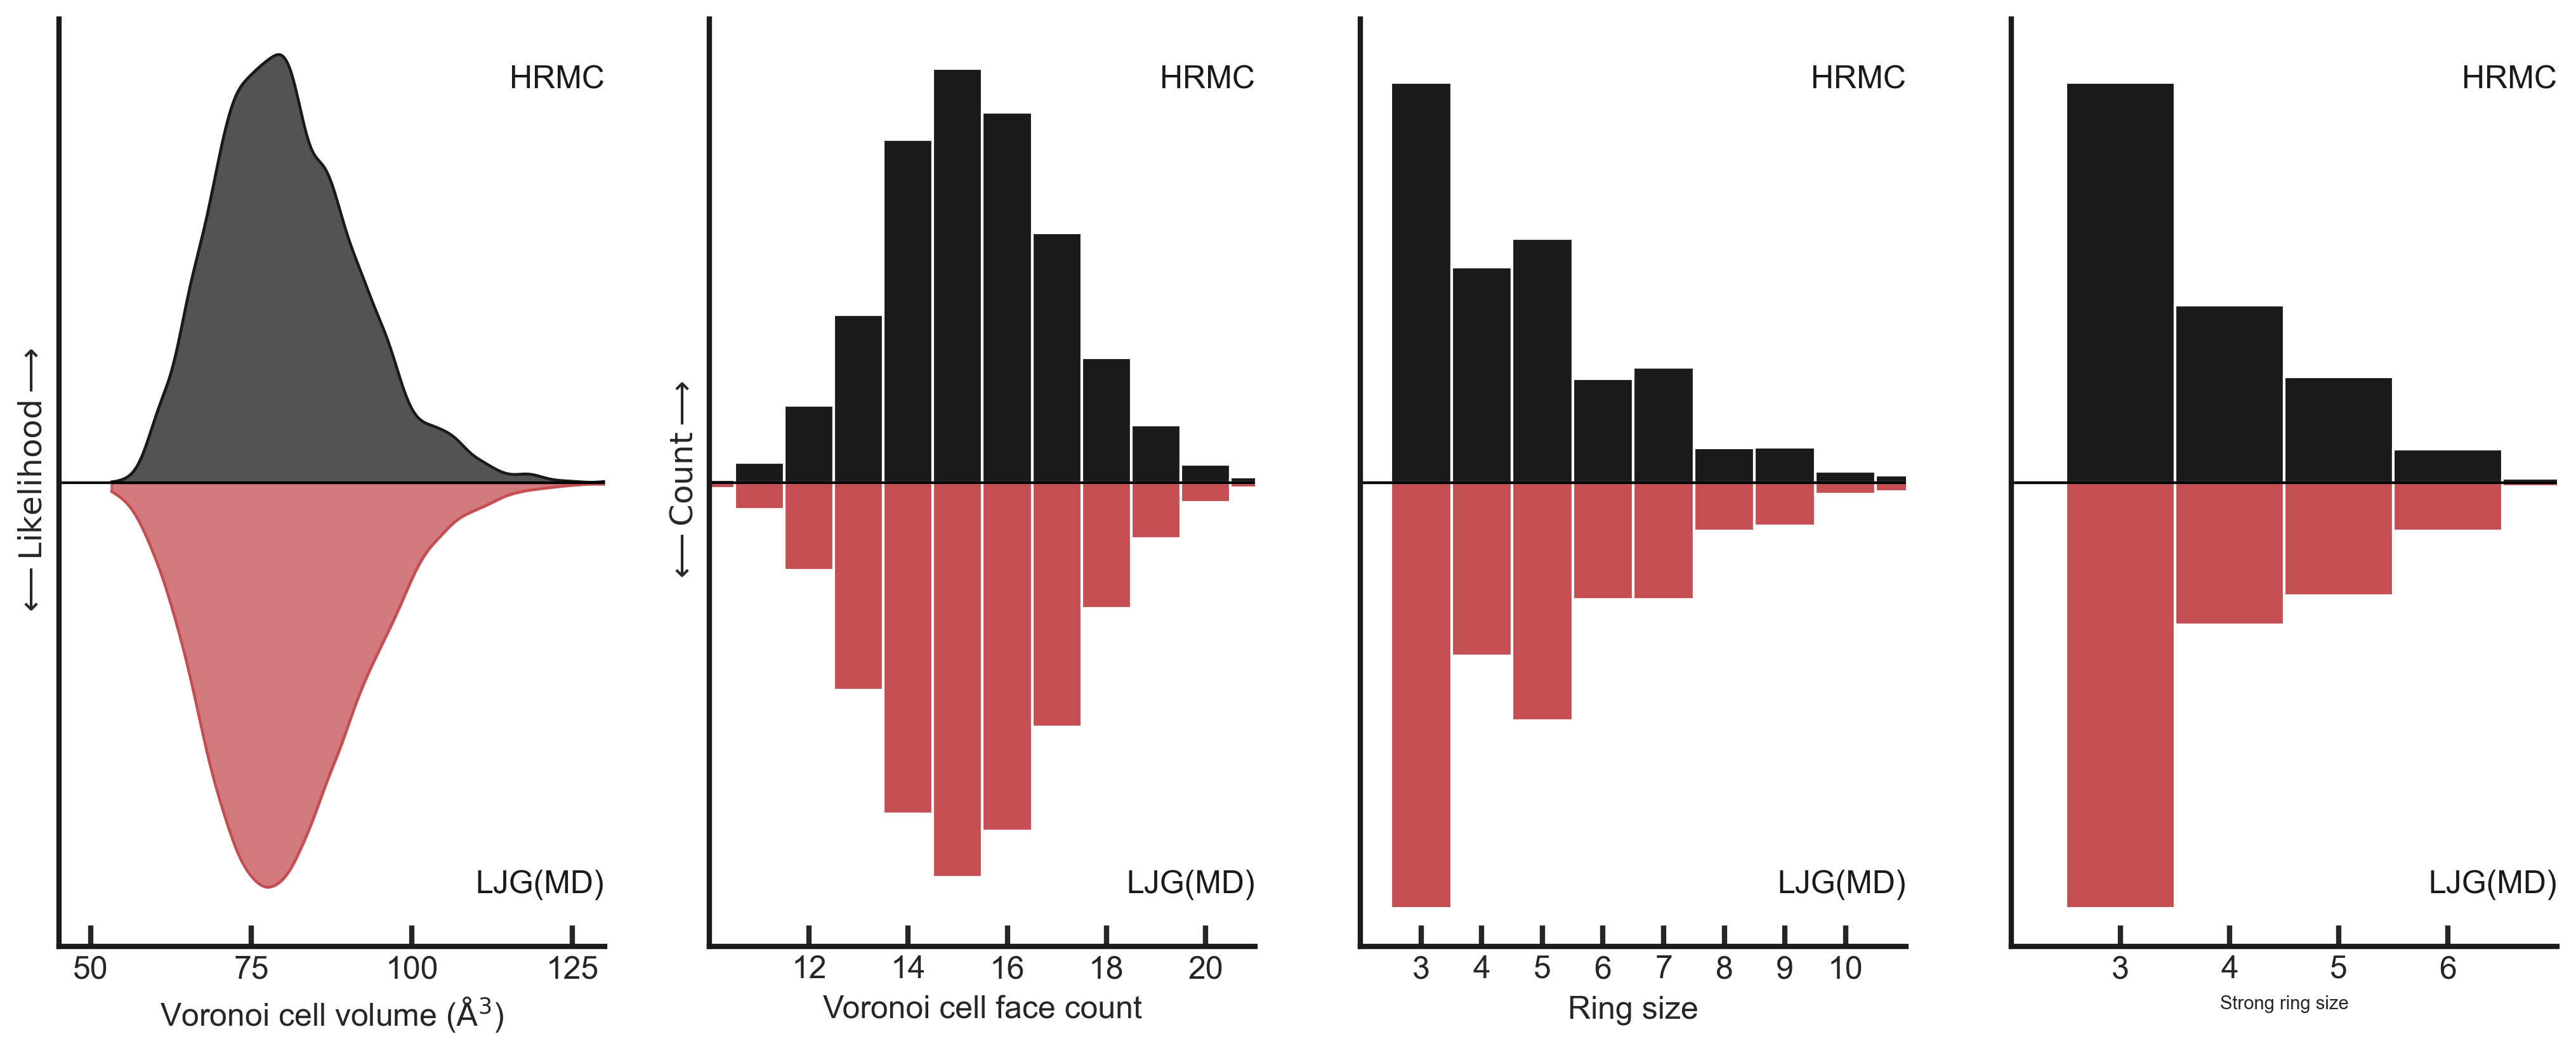

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 6), dpi=300)

left, width = .25, .1
bottom, height = .25, .1
right = left + width
top = bottom + height

# voronoi volume kde.
xrange = plot_voronoi_volume_kde(
    axes[0], voronoi_statistics, model='hrmc'
)
plot_voronoi_volume_kde(
    axes[0], voronoi_statistics, model='ljg_md', xrange=xrange, colour='r'
);
axes[0].axhline(y=0, linestyle='-',linewidth=1, color='black')

# voronoi neighbours histogram.
plot_voronoi_neighbour_histogram(
    axes[1], voronoi_statistics, model='hrmc'
)
plot_voronoi_neighbour_histogram(
    axes[1], voronoi_statistics, model='ljg_md', colour='r'
)
axes[1].axhline(y=0, linestyle='-',linewidth=1, color='black')

# ring statistics.
plot_ring_counts(axes[2], ring_statistics, model='hrmc')
plot_ring_counts(axes[2], ring_statistics, model='ljg_md')

# strong ring statistics.
plot_ring_counts(axes[3],  ring_statistics, model='hrmc', 
    ring_type='strong_rings'
)
plot_ring_counts(axes[3], ring_statistics, model='ljg_md', 
    ring_type='strong_rings'
)

label_top_and_bottom_axes(axes, bottom_label='LJG(MD)')
fig.subplots_adjust(bottom=0.3, wspace=0.33)
plt.tight_layout(pad=2)
plt.savefig('figures/si/figS8.pdf', dpi=600)
plt.show()